# MLP Implementation with PyTorch

In [ ]:
!nvidia-smi

Sun May  7 13:24:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [3]:
ROOT = 'dataset'

train_data = datasets.MNIST(ROOT, train=True, download=True)

100%|██████████| 9912422/9912422 [00:07<00:00, 1244118.18it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 107783.38it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:04<00:00, 379700.37it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4700352.52it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

mean.item(), std.item()

(0.13066047430038452, 0.30810779333114624)

In [5]:
train_transformer = transforms.Compose([
    transforms.RandomRotation(10, fill=0),
    transforms.RandomCrop(28, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_trainsforer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [6]:
train_data = datasets.MNIST(ROOT, train=True, transform=train_transformer, download=True)
test_data = datasets.MNIST(ROOT, train=False, transform=test_trainsforer, download=True)

len(train_data), len(test_data)

(60000, 10000)

In [7]:
def plots(dataset: list, images_nums: int) -> None:
    rows = int(np.sqrt(images_nums))
    cols = int(np.sqrt(images_nums))

    images = [image for image, label in [dataset[i] for i in range(images_nums)]]

    fig = plt.figure()
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

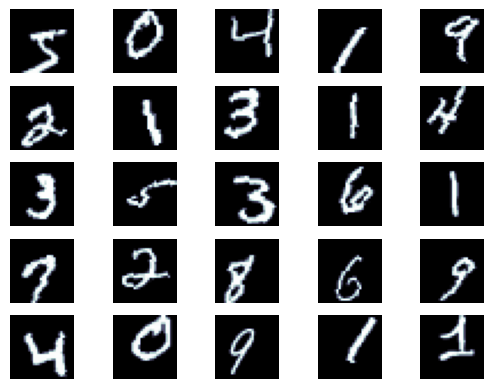

In [8]:
plots(train_data, 25)

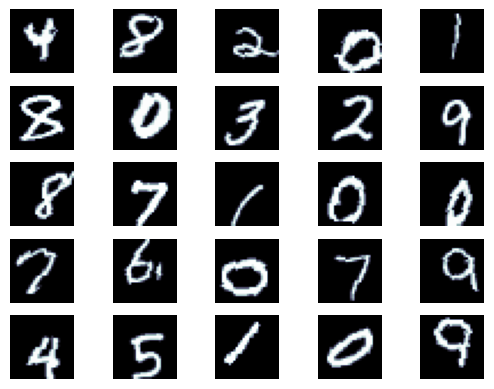

In [11]:
train_ratio = 0.9
total_imgs = len(train_data)
train_num = int(total_imgs*train_ratio)
valid_num = total_imgs - train_num

train_data, valid_data = data.random_split(train_data, [train_num, valid_num])
plots(train_data, 25)

In [12]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


In [13]:
"""
By creating a deep copy, we create a new object with the same values as the original object.
The new object is a completely independent copy, and modifying it will not affect the original object.
"""
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transforms = test_trainsforer

In [14]:
batch_size = 32

train_iterator = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_iterator = data.DataLoader(valid_data, batch_size=batch_size)
test_iterator = data.DataLoader(test_data, batch_size=batch_size)

In [ ]:
"""
Flatten 1x28x28 (1 color channel, 28 pixels height and width) image 
into a 784 element vector, also called 784 features.

Model: 28*28(input) -> 784(flatten) -> [250 -> 100](hidden) -> 10(output)
"""

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    """
    The forward function computes output Tensors from input Tensors. Default '__call__()'
    The backward function receives the gradient of the output Tensors with respect to some scalar value, 
        and computes the gradient of the input Tensors with respect to that same scalar value.
    """
    def forward(self, x):
        # x = [batch_size, height, width]
        batch_size = x.shape[0]
        """
        -1 is used to flatten the feature dimensions of the tensor, 
        while preserving the batch dimension.
        """
        x = x.view(batch_size, -1)

        # x = [batch_size, height*width]
        H1 = F.relu(self.input_fc(x))

        # x = [batch_size, 250]
        H2 = F.relu(self.hidden_fc(H1))

        """
        PyTorch combines activation functions to be applied on the output with the functions 
        which calculate the loss of a neural network. This is done for numerical stability.
        """
        # x = [batch_size, 100]
        y_hat = self.output_fc(H2)
        
        return y_hat, H2

In [ ]:
input_dim, output_dim = 28*28, 10
net = MLP(input_dim=input_dim, output_dim=output_dim,)

In [ ]:
# Calculate the number of trainable parameters (weights and biases) in the mode (ALL)
def count_parameters(model) -> int:
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

# 784*250 + 250*100 + 100*10 + (250+100+10)bias = 222,360
print(f'The model has {count_parameters(net):,} trainable parameters')

The model has 222,360 trainable parameters


### Train the model
1. Pass a batch of data through your model
2. Calculate the loss of the batch by comparing the model's predictions against actual labels
3. Calculate the gradient of each of parameters with respect to the loss
4. Update parameters by substracting their gradient multiplied(x) by a small learning rate

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=0.001)
loss = nn.CrossEntropyLoss()

# Place the model(net) and criterion(loss) on to the device by using the .to method.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
loss = loss.to(device)

device, torch.cuda.device_count()

(device(type='cuda'), 1)

In [ ]:
# Calculate Accuracy
def calculate_accuracy(y_hat, y) -> float:
    """
    y_hat: batch_size*10 -> argmax(1): batch_size*1
    view_as: 1*batch_size -> batch_size*1
    eq().sum(): number of correct prediction(s)
    """
    best = y_hat.argmax(dim=1, keepdim=True)
    delta = best.eq(y.view_as(best)).sum()
    acc = delta.float() / y.shape[0]    # batch size
    return acc

### Training
- Put model into `train` mode
- Iterate over dataloader, returning batches of (image, label)
- Place the batch on to our device
- ***Clear the gradients*** calculated from the last batch
- Pass the batch of images, `x`, through to model to get predictions, `y_pred`
- Calculate the ***loss*** between predictions and the actual labels
- Calculate the ***accuracy*** between predictions and the actual labels
- Calculate the ***gradients*** of each parameter
- Update the parameters by taking an optimizer step
- Update the metrics

In [ ]:
# Train
def train(net, iterator, optimizer, criterion, device):
    epoch_loss, epoch_acc = 0., 0.
    net.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_hat, _ = net(x)   # forward()

        loss = criterion(y_hat, y)
        acc = calculate_accuracy(y_hat, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)    # batch size

### Evaluating
The evaluation loop is similar to the training loop. The differences are:
- we put our model into evaluation mode with `model.eval()`
- we wrap the iterations inside a `with torch.no_grad()`
- we do not zero gradients as we are not calculating any
- we do not calculate gradients as we are not updating parameters
- we do not take an optimizer step as we are not calculating gradients

In [ ]:
# Evaluate
def evaluate(net, iterator, criterion, device):
    epoch_acc, epoch_loss = 0., 0.
    net.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc='Evaluating', leave=False):
            x = x.to(device)
            y = y.to(device)

            y_hat, _ = net(x)
            loss = criterion(y_hat, y)
            acc = calculate_accuracy(y_hat, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time):
    end_time = time.monotonic()
    elapsed_time = end_time - start_time    # sec
    elapsed_mins = elapsed_time // 60
    elapsed_secs = elapsed_time - elapsed_mins*60
    return int(elapsed_mins), int(elapsed_secs)

In [ ]:
# Ready to train!
epochs = 20

best_valid_loss = float('inf')

for epoch in trange(epochs):
    start_time = time.monotonic()

    train_loss, train_acc = train(net, train_iterator, optimizer, loss, device)
    valid_loss, valid_acc = evaluate(net, valid_iterator, loss, device)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # Save parameters
        torch.save(net.state_dict(), 'mlp.pt')

    epoch_mins, epoch_secs = epoch_time(start_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%')

  0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 32s
	Train Loss: 1.539 | Train Acc: 48.95%
	Valid Loss: 0.935 | Valid Acc: 71.88%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 0.643 | Train Acc: 81.12%
	Valid Loss: 0.505 | Valid Acc: 85.26%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 0.420 | Train Acc: 87.77%
	Valid Loss: 0.394 | Valid Acc: 88.61%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 27s
	Train Loss: 0.335 | Train Acc: 90.05%
	Valid Loss: 0.342 | Valid Acc: 90.18%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 28s
	Train Loss: 0.294 | Train Acc: 91.43%
	Valid Loss: 0.282 | Valid Acc: 92.32%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 27s
	Train Loss: 0.267 | Train Acc: 92.19%
	Valid Loss: 0.264 | Valid Acc: 92.20%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.242 | Train Acc: 92.98%
	Valid Loss: 0.258 | Valid Acc: 91.99%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 28s
	Train Loss: 0.224 | Train Acc: 93.32%
	Valid Loss: 0.224 | Valid Acc: 93.30%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.211 | Train Acc: 93.81%
	Valid Loss: 0.217 | Valid Acc: 93.68%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 27s
	Train Loss: 0.203 | Train Acc: 93.94%
	Valid Loss: 0.215 | Valid Acc: 93.68%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 27s
	Train Loss: 0.192 | Train Acc: 94.22%
	Valid Loss: 0.194 | Valid Acc: 94.33%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 27s
	Train Loss: 0.187 | Train Acc: 94.37%
	Valid Loss: 0.194 | Valid Acc: 94.81%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 27s
	Train Loss: 0.178 | Train Acc: 94.70%
	Valid Loss: 0.184 | Valid Acc: 94.63%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 27s
	Train Loss: 0.171 | Train Acc: 94.83%
	Valid Loss: 0.179 | Valid Acc: 95.01%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 27s
	Train Loss: 0.165 | Train Acc: 95.03%
	Valid Loss: 0.174 | Valid Acc: 95.15%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 27s
	Train Loss: 0.163 | Train Acc: 95.05%
	Valid Loss: 0.160 | Valid Acc: 95.16%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 27s
	Train Loss: 0.158 | Train Acc: 95.23%
	Valid Loss: 0.167 | Valid Acc: 94.91%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 27s
	Train Loss: 0.155 | Train Acc: 95.37%
	Valid Loss: 0.166 | Valid Acc: 95.11%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 27s
	Train Loss: 0.152 | Train Acc: 95.41%
	Valid Loss: 0.154 | Valid Acc: 95.56%


Training:   0%|          | 0/1688 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 27s
	Train Loss: 0.147 | Train Acc: 95.62%
	Valid Loss: 0.161 | Valid Acc: 95.26%


In [ ]:
# Load parameters
net = MLP(input_dim, output_dim)
net.load_state_dict(torch.load('mlp.pt'))
net = net.to(device)
net.eval()

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
# Test model
test_loss, test_acc = evaluate(net, test_iterator, loss, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/313 [00:00<?, ?it/s]

Test Loss: 0.090 | Test Acc: 97.28%


In [ ]:
def get_predictions(net, iterator, device):
    net.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = net(x)
            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
# prediction
images, labels, probs = get_predictions(net, test_iterator, device)
pred_labels = torch.argmax(probs, 1)
# true
sample = []
for image, label, prob in zip(images, labels, probs):
    sample.append((image, label, prob))

In [ ]:
def plot_result(n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(20, 10))

    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        true_image, true_label, t_probs = sample[random.randint(0, len(test_data))]
        t_prob = t_probs[true_label]
        pred_prob, pred_label = torch.max(t_probs, dim=0)
        ax.imshow(true_image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({t_prob:.3f})\n'
                     f'pred label: {pred_label} ({pred_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.5)

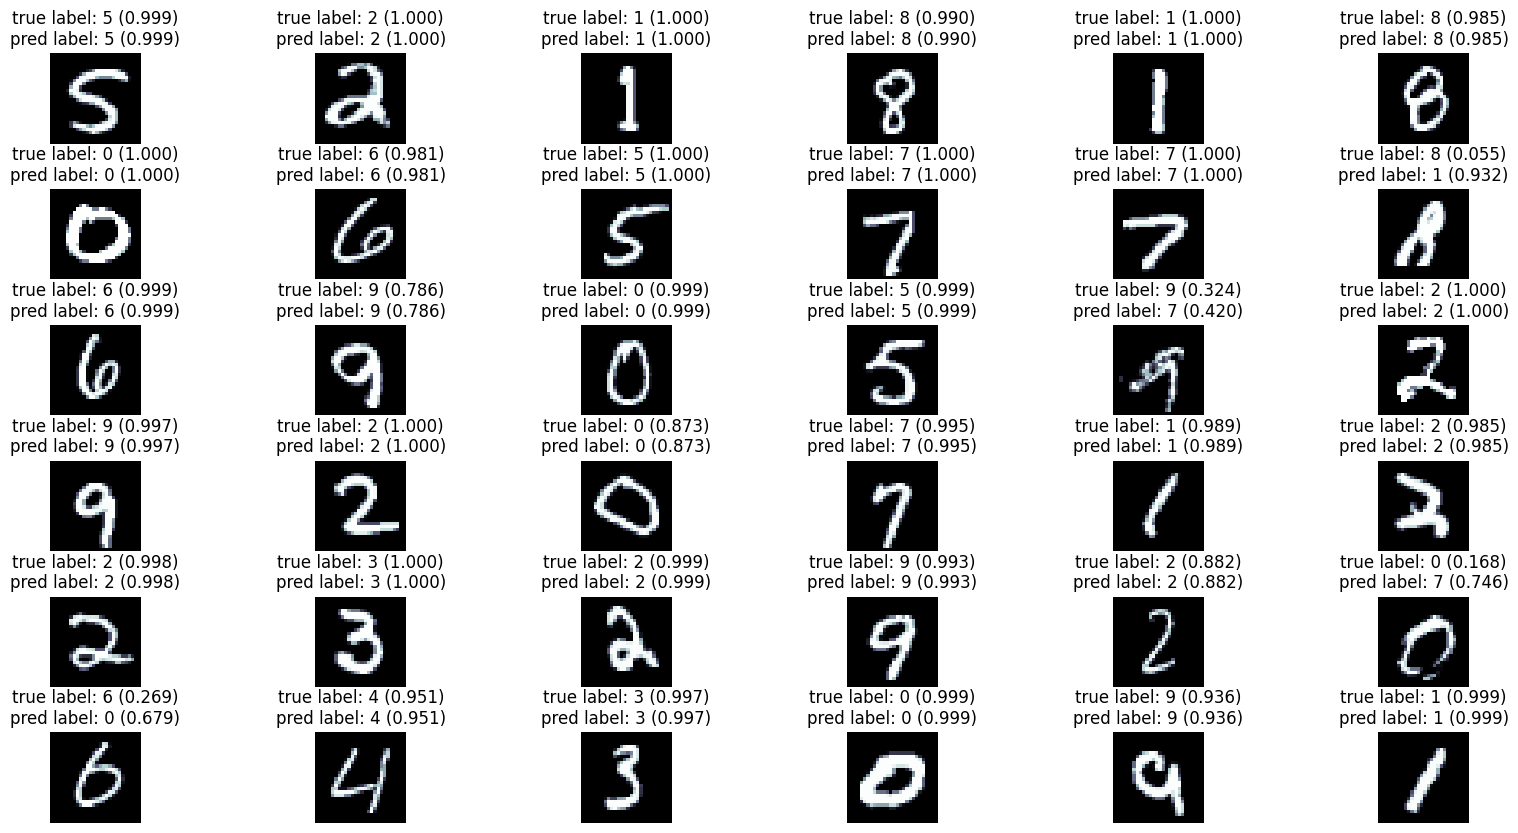

In [ ]:
n_images = 36
plot_result(n_images)